**Exploration notebook**

Exploration notebook to play with dataset in order to understand what do we have in data.

Before explore data, we use traditional methods to clean text (remove stopwords, abbreviations, punctuations, links, etc). We add the possibility to lemmatize words. Lemmatize allow us to change words like "loving", "loved", into "lov". Thus, we do not take into account grammar or conjugation.

Then, we use simple wordcloud to see most frequent words for each label. Note that this is *toxic comments* so you can see lot of f\*\*\* words.

Finally we use *NMF* to check patterns in our data. For example, NMF allow us to find "topic" in text data. We also use TSNE to visualize result from NMF. We could see NMF as unsupervised analysis, we take our labels and without considering it, the algorithm try to find patterns in our data.

# Library

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
import unidecode
import string
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# Data

## train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
df_train.comment_text = df_train.comment_text.str.replace("\n", "")
targets = [x for x in df_train.columns.tolist() if x not in ["id", "comment_text"]]
print("Labels are: " + ", ".join(targets) + ".")
df_train["label"] = df_train[targets].sum(axis=1) > 0
print("We have " + str(df_train.shape[0]) + " comments.")
df_train.head()

Labels are: toxic, severe_toxic, obscene, threat, insult, identity_hate.
We have 159571 comments.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0,False
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,False
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,False
3,0001b41b1c6bb37e,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0,False
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,False


# Target

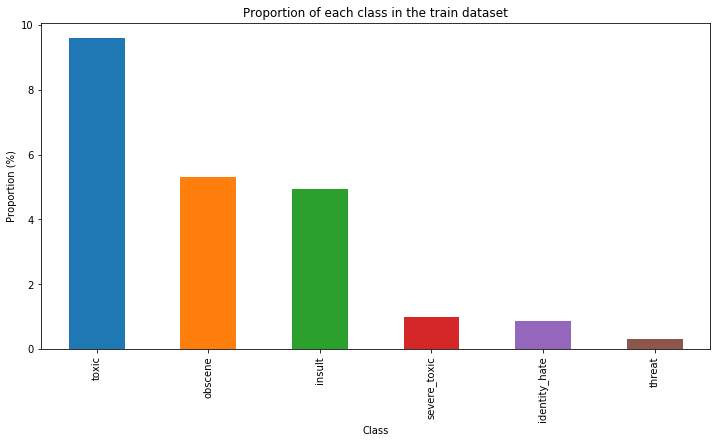

In [3]:
plt.figure(figsize=(12,6))
(100*df_train[[
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]].sum() / df_train.shape[0]).sort_values(ascending=False).plot.bar()
plt.title("Proportion of each class in the train dataset")
plt.ylabel("Proportion (%)")
plt.xlabel("Class")
plt.show()

In [4]:
df_combs = df_train.groupby([
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]).size().rename("proportion").sort_values(ascending=False).reset_index()
df_combs["proportion"] = np.round(
    100 * df_combs["proportion"] / df_train.shape[0], 1)
df_combs.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,proportion
0,0,0,0,0,0,0,89.8
1,1,0,0,0,0,0,3.6
2,1,0,1,0,1,0,2.4
3,1,0,1,0,0,0,1.1
4,1,0,0,0,1,0,0.8


Real imbalanced data, almost 90% of comments are clean, target could be really rare.

Only for toxic comments, we remove clean comments. We could make the same analysis on all comments, but we want to focus on what is a toxic comment.

Do not hesitate to rerun this part (especially NMF) on full dataset to analyze results.

In [5]:
df_train = df_train.loc[df_train.label].drop("label", axis=1).reset_index(drop=True)
print("We keep " + str(df_train.shape[0]) +
      " comments labelled with at least one of toxic categories.")
df_train.head()

We keep 16225 comments labelled with at least one of toxic categories.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
1,0005c987bdfc9d4b,Hey... what is it..@ | talk .What is it... an ...,1,0,0,0,0,0
2,0007e25b2121310b,"Bye! Don't look, come or think of comming back...",1,0,0,0,0,0
3,001810bf8c45bf5f,You are gay or antisemmitian? Archangel WHite ...,1,0,1,0,1,1
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


# Text cleaning

In [6]:
def clean_text(x, lemmatize=False):
    if type(x) == np.ndarray:
        x = pd.Series(x)
    # To lower
    x = x.str.lower()
    # Remove digits
    x = x.str.replace('\d+', '')
    # Remove url
    x = x.str.replace('http\S+', "")
    # Remove extra white spaces
    x = x.str.replace('[^\w\s]', ' ')
    # Replace common abbreviation
    x = x.str.replace(r"what's", "what is ")
    x = x.str.replace(r"\'s", " ")
    x = x.str.replace(r"\'ve", " have ")
    x = x.str.replace(r"can't", "cannot ")
    x = x.str.replace(r"n't", " not ")
    x = x.str.replace(r"i'm", "i am ")
    x = x.str.replace(r"\'re", " are ")
    x = x.str.replace(r"\'d", " would ")
    x = x.str.replace(r"\'ll", " will ")
    x = x.str.replace(r"\'scuse", " excuse ")
    # Remove white space begin end string
    x = x.str.strip()
    if lemmatize:
        # Remove stopwords
        stop_words = stopwords.words('english') + ["wikipedia", "wiki"]
        x = x.map(lambda sentence : " ".join([word for word in sentence.split(" ") if (word not in stop_words) and (len(word) > 1)]))
        lemmatiser = WordNetLemmatizer()
        x = x.map(lambda sentence : " ".join([lemmatiser.lemmatize(word.strip()) for word in sentence.split(' ') if word not in ["", " ", "  "]]))
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    x = x.map(lambda sentence: sentence.translate(translator))
    # Remove stopwords
    stop_words = stopwords.words('english') + ["Wikipedia", "wikipedia", "wiki", "Wiki"]
    x = x.map(lambda sentence : " ".join([word for word in sentence.split(" ") if (word not in stop_words) and (len(word) > 1)]))
    return x.values

In [7]:
df_train["comment_text_clean"] = clean_text(df_train["comment_text"], lemmatize=False)
df_train["comment_text_lemmatize"] = clean_text(df_train["comment_text"], lemmatize=True)

In [8]:
print("Compare raw comment, cleaned, and cleaned + lemmatized:")
print("---------------")
i = 1
print(df_train.loc[i, "comment_text"])
print("---------------")
print(df_train.loc[i, "comment_text_clean"])
print("---------------")
print(df_train.loc[i, "comment_text_lemmatize"])
print("---------------")

Compare raw comment, cleaned, and cleaned + lemmatized:
---------------
Hey... what is it..@ | talk .What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?Ask Sityush to clean up his behavior than issue me nonsensical warnings...
---------------
hey talk exclusive group wp talibans good destroying self appointed purist gang one asks questions abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warnings
---------------
hey talk exclusive group wp taliban good destroying self appointed purist gang one asks question abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warning
---------------


# Explore text

## WordCloud

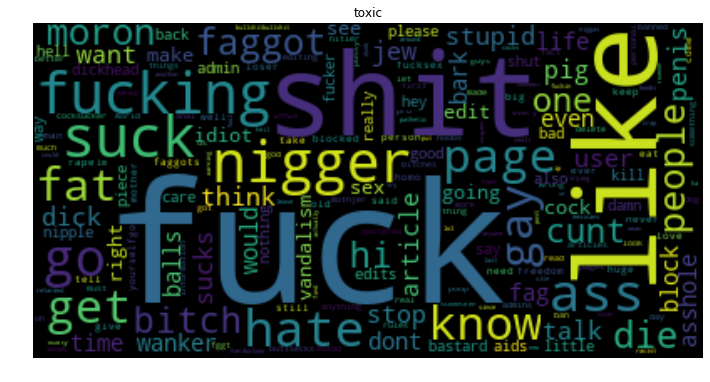

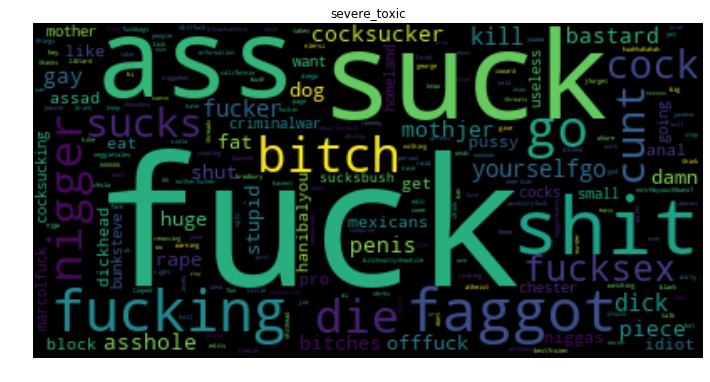

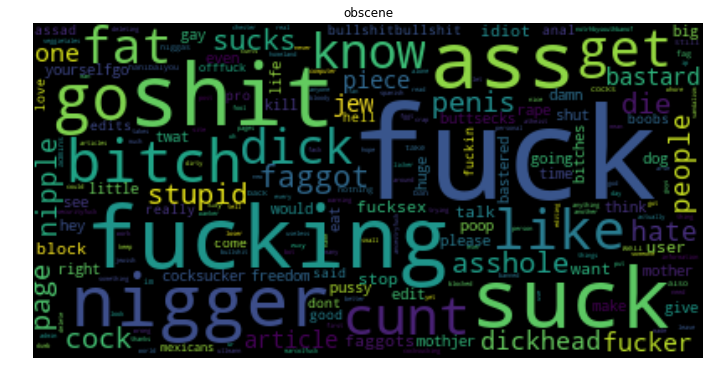

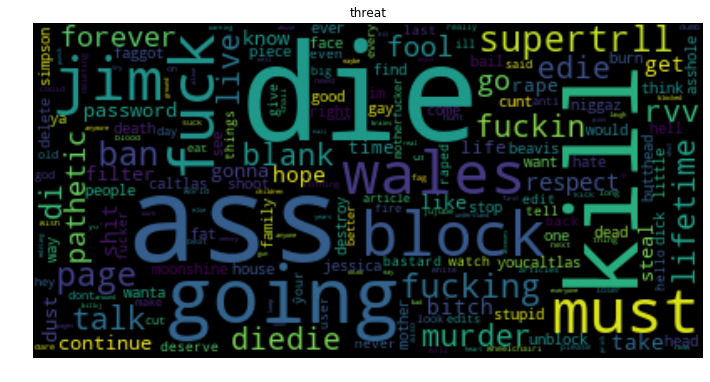

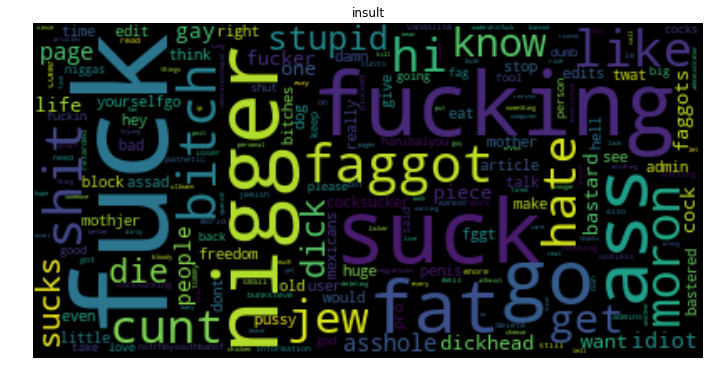

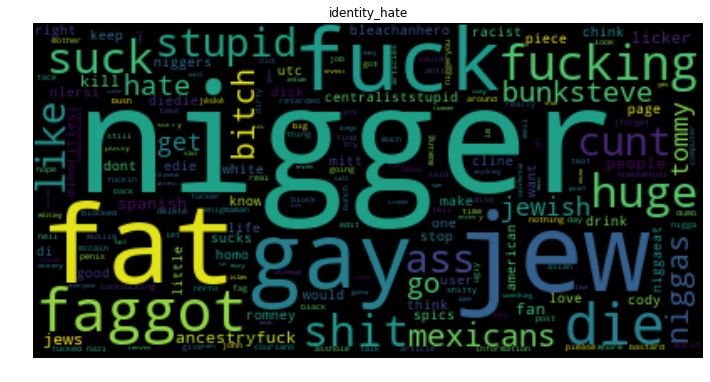

In [9]:
word_occurencies = [
    pd.Series(
        Counter([
            item for sublist in df_train.comment_text_clean.loc[
                df_train[target] == 1].tolist() for item in sublist.split(" ")
        ])).sort_values(ascending=False).head(500) for target in targets
]

for i, words_list in enumerate(word_occurencies):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=words_list.to_dict())
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(targets[i])
    plt.axis("off")
    plt.show()

del wordcloud
del word_occurencies

## NMF

### Functions

In [10]:
def get_tfidf(serie,
              max_features=1000,
              max_df=0.95,
              min_df=5,
              strip_accents="unicode"):
    if type(serie.iloc[0]) == type([]):
        serie = serie.map(lambda x: " ".join(x)).tolist()
    tfidf_vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        strip_accents="unicode",
        stop_words=None,
        lowercase=False)
    tfidf = tfidf_vectorizer.fit_transform(serie)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf, tfidf_feature_names


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join(
            [feature_names[i]
             for i in topic.argsort()[:-no_top_words - 1:-1]]))


def get_nmf_activation(nmf, tfidf_feature_names):
    df = pd.DataFrame(
        nmf.components_,
        columns=tfidf_feature_names,
        index=[str(x) for x in range(nmf.components_.shape[0])]).T
    df.index = df.index.rename("word")
    return df


def get_nmf_weights(nmf, tfidf, index):
    return pd.DataFrame(
        nmf.transform(tfidf),
        columns=[str(x) for x in range(nmf.components_.shape[0])],
        index=index)


def viz_activation_top_words(activation, threshold=1):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(activation.loc[activation.max(axis=1) > threshold].sort_values(
        activation.columns.tolist(), ascending=False))
    plt.show()


def viz_top_word_by_topic(activation):
    for topic in activation:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

        activation = activation.sort_values(topic, ascending=False)

        activation[topic].head(100).reset_index(drop=True).plot(ax=axes[0])
        axes[0].set_title('Activation decreasing')
        activation.head(30).reset_index().plot.bar(
            x="word", y=topic, ax=axes[1])
        axes[1].set_title('Top words')
        plt.suptitle(
            topic + " : " + " ".join(activation.index[:10].tolist()),
            fontsize=20)
        plt.subplots_adjust(top=0.8)
        plt.show()


def viz_weights_by_topic(weights):
    fig, axes = plt.subplots(
        nrows=int(np.ceil(weights.shape[1] / 4)), ncols=4, figsize=(15, 6))

    for i in range(weights.shape[1]):
        if ((weights.shape[1] / 4) == 1):
            ax = axes[i]
        else:
            ax = axes[int(i / 4), (i % 4)]
        weights[str(i)].sort_values(ascending=False).reset_index(
            drop=True).plot(ax=ax)
        ax.set_title("Topic " + str(i))

### Compute NMF

In [11]:
path_tfidf = "../data/work/tfidf.p"
path_tfidf_features_names = "../data/work/tfidf_feature_names.p"
path_nmf = "../data/work/nmf.p"

if os.path.isfile(path_tfidf):
    tfidf = pickle.load(open(path_tfidf, "rb"))
    tfidf_feature_names = pickle.load(open(path_tfidf_features_names, "rb"))
else:
    tfidf, tfidf_feature_names = get_tfidf(
        df_train.comment_text_lemmatize, max_features=5000)
    pickle.dump(tfidf, open(path_tfidf, "wb"))
    pickle.dump(tfidf_feature_names, open(path_tfidf_features_names, "wb"))
    
if os.path.isfile(path_nmf):
    nmf = pickle.load(open(path_nmf, "rb"))
else:
    nmf = NMF(
        n_components=20, alpha=0.1, l1_ratio=0.5, init='nndsvd').fit(tfidf)
    pickle.dump(nmf, open(path_nmf, "wb"))

### Topics analysis

#### Most representative words in each topic

In [12]:
display_topics(nmf, tfidf_feature_names, 10)

Topic 0:
fuck shut want fuckin fag nigger mother fucker alone hey
Topic 1:
know article people stupid one think time want make block
Topic 2:
suck cock ball yeah big hey penis lick love ur
Topic 3:
fucking retard mother moron twat cock pussy fucker kill bastard
Topic 4:
bitch son little stupid fuckin motherfucker ur im hey pussy
Topic 5:
gay fag ur sex im homosexual hi men think guy
Topic 6:
shit piece eat give die little full dont nigger worthless
Topic 7:
faggot nigger hey huge cocksucking total delete little hi dead
Topic 8:
go die ahead away kill message mother back self screw
Topic 9:
asshole hey stick mother motherfucker blocked prick huge son sandbox
Topic 10:
page talk user delete edit leave please comment vandalize editing
Topic 11:
cunt stupid fat block mother nigger ignorant bastard ya im
Topic 12:
get life loser nerd job sad real need hope lost
Topic 13:
idiot read explain block think information vandalism change blocked sound
Topic 14:
hello dickhead girl please know lover

#### Activation matrix: top words

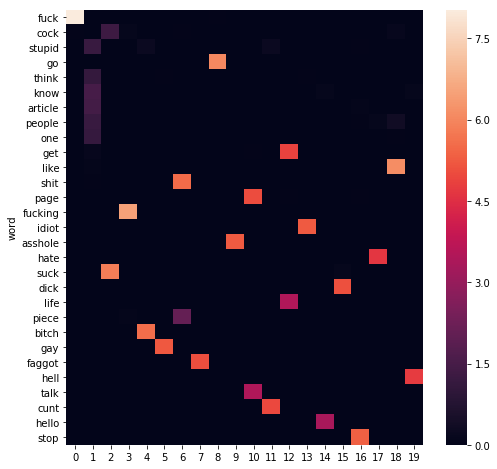

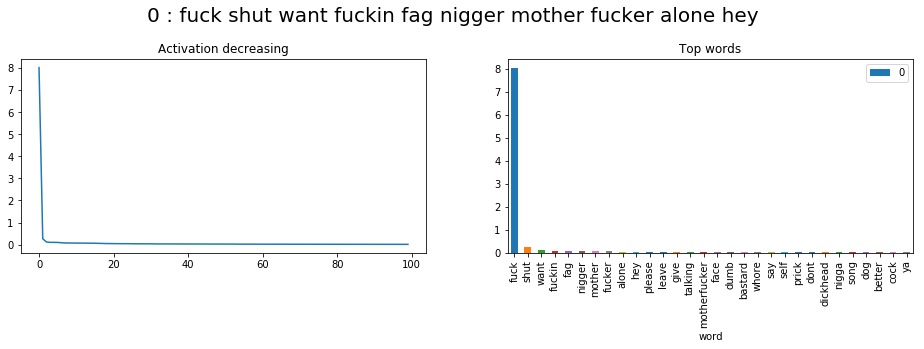

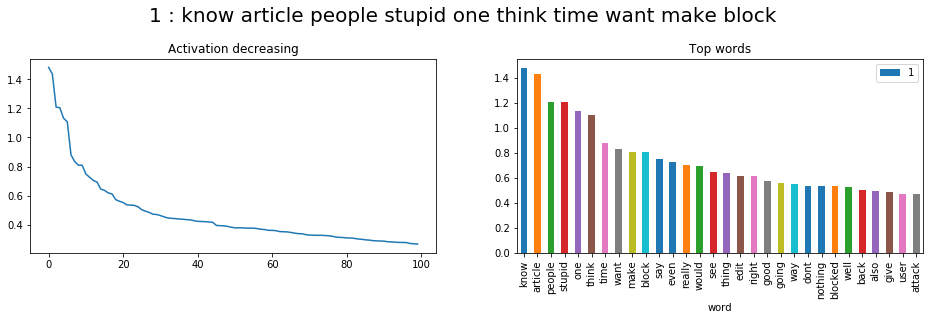

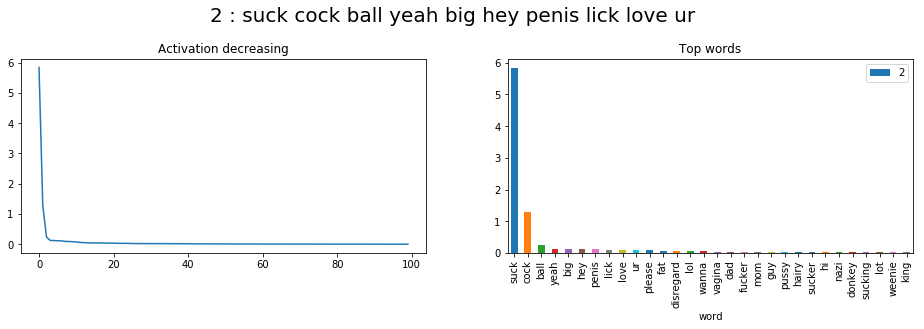

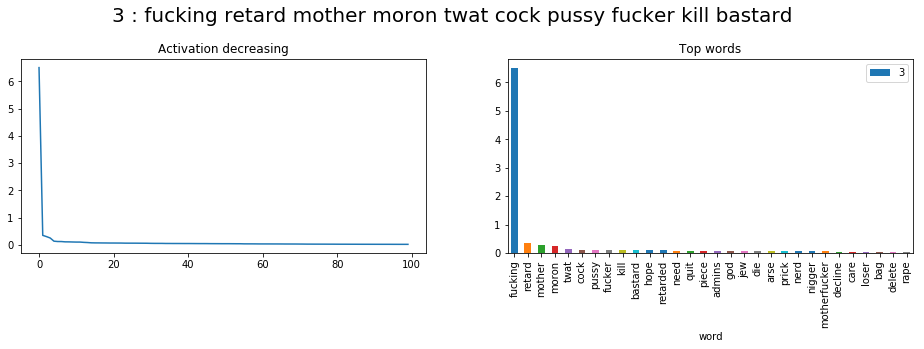

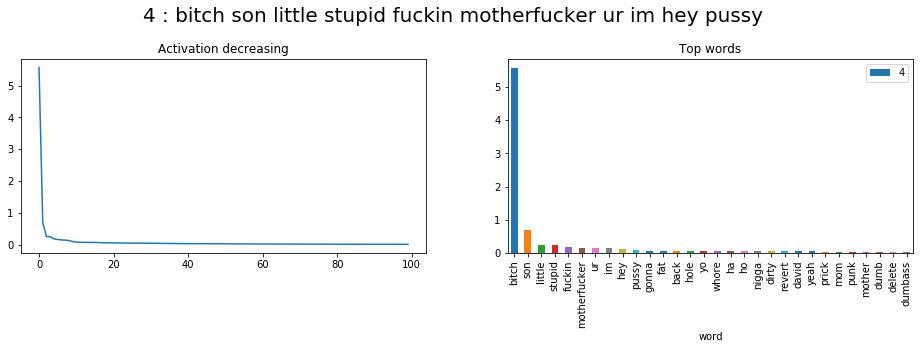

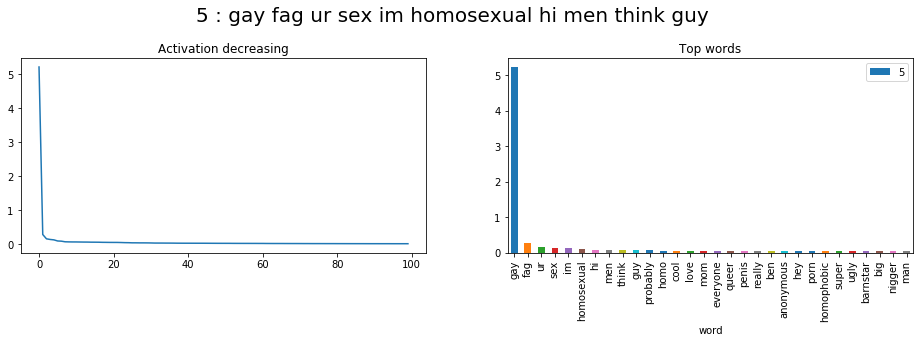

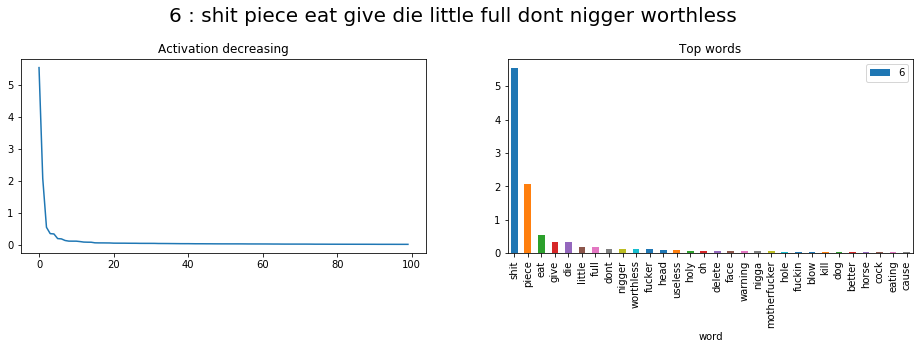

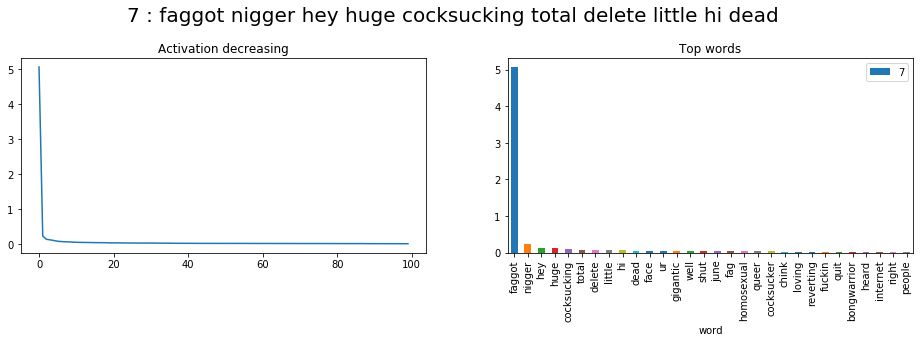

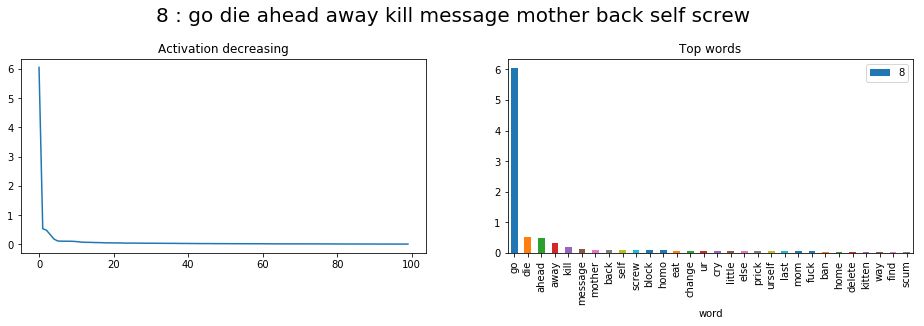

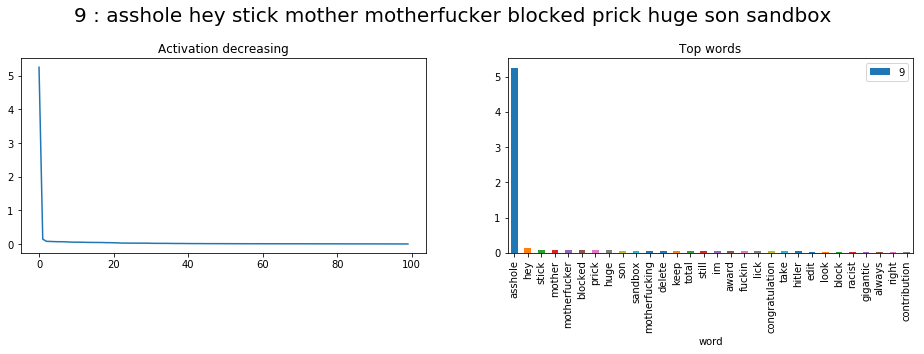

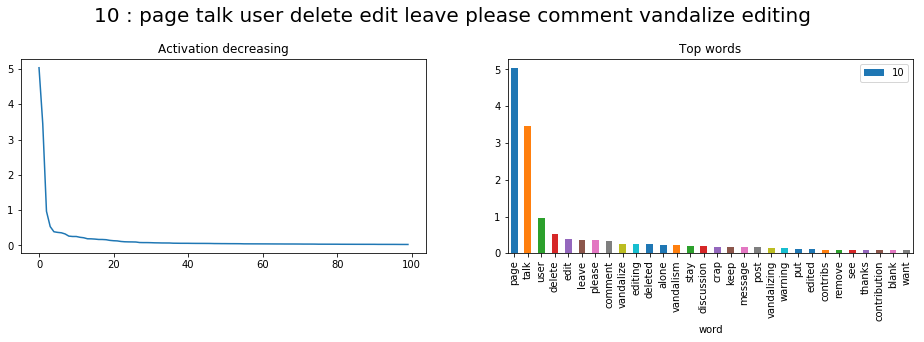

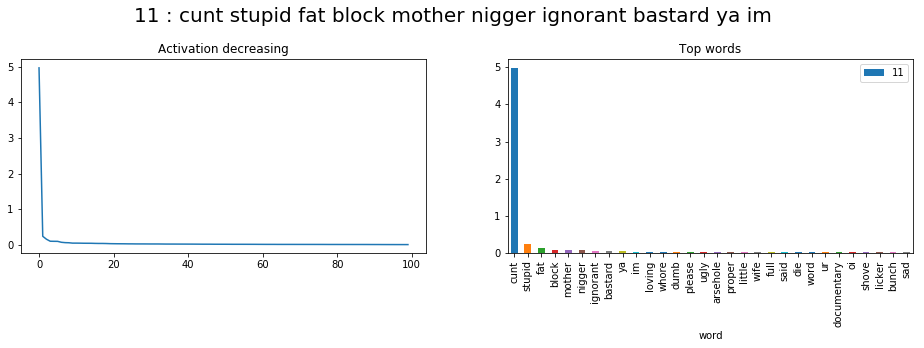

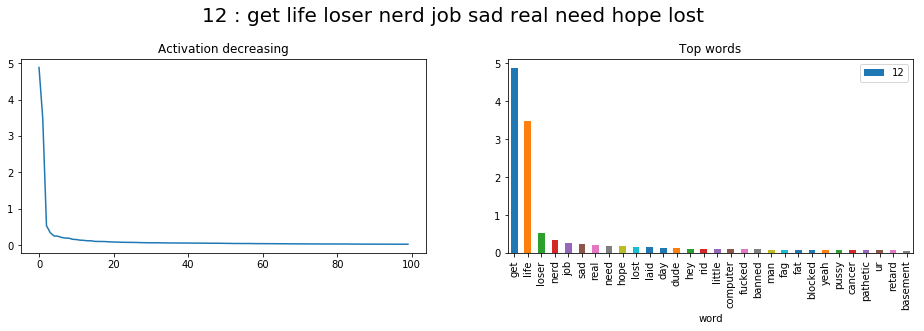

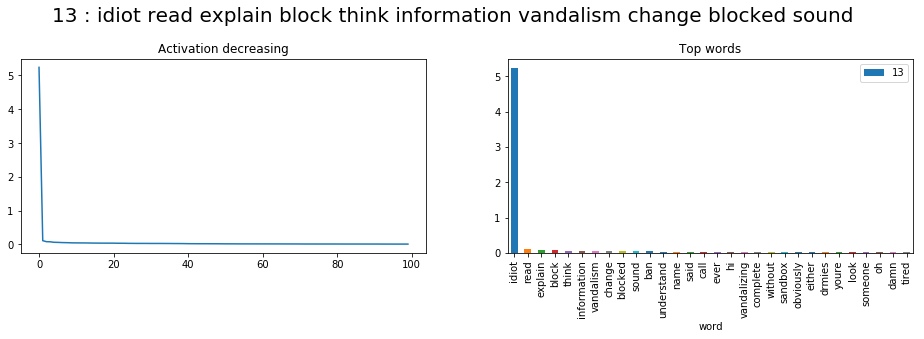

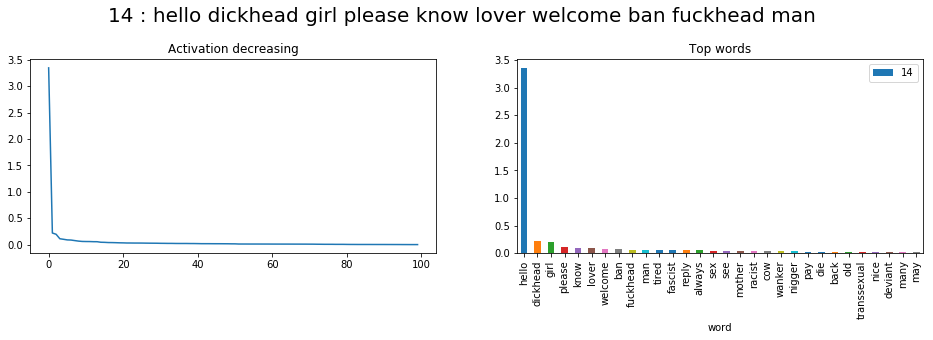

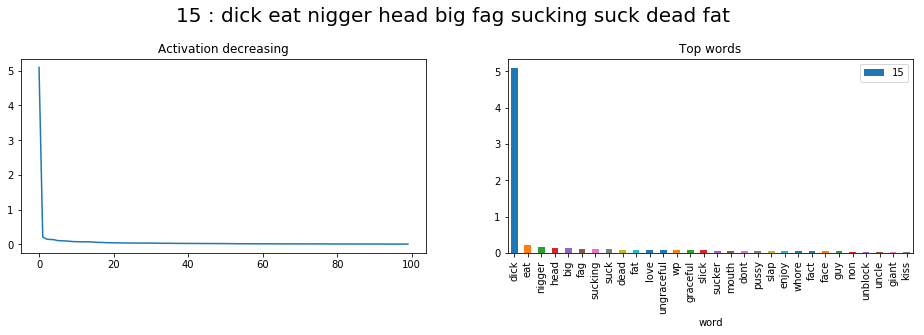

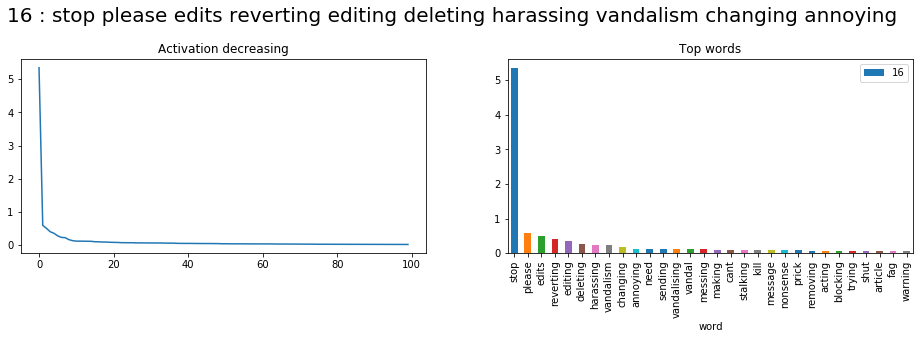

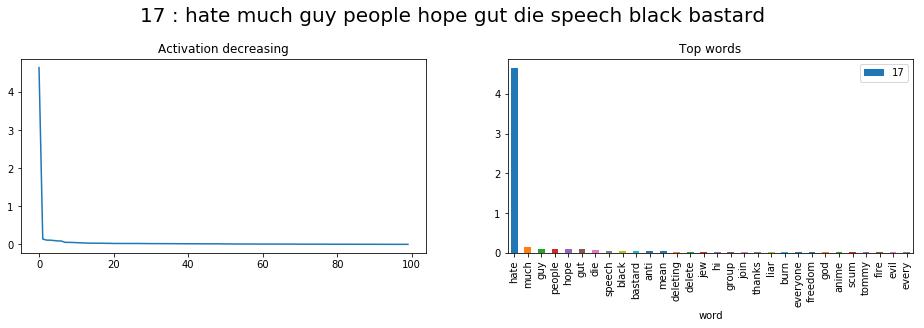

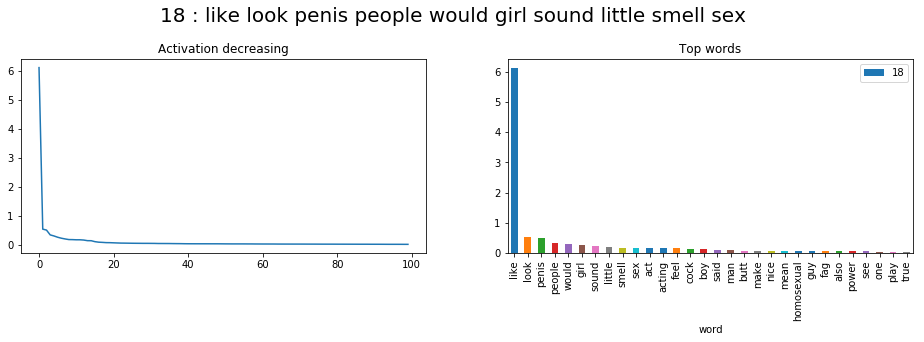

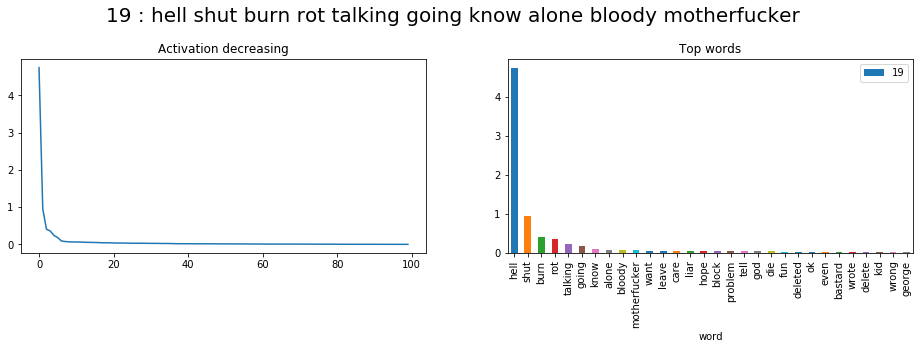

In [13]:
activation = get_nmf_activation(nmf, tfidf_feature_names)
weights = get_nmf_weights(nmf, tfidf, df_train.id)

viz_activation_top_words(activation)
viz_top_word_by_topic(activation)

In [14]:
df_topic_targets = pd.merge(
    weights.idxmax(axis=1).reset_index().rename(columns={0: "topic"}),
    df_train[["id"] + targets],
    on="id")
df_topic_targets.head()

,id,topic,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0002bcb3da6cb337,1,1,1,1,0,1,0
1,0005c987bdfc9d4b,1,1,0,0,0,0,0
2,0007e25b2121310b,1,1,0,0,0,0,0
3,001810bf8c45bf5f,5,1,0,1,0,1,1
4,00190820581d90ce,0,1,0,1,0,1,0


In [15]:
df_topic_targets_proportion = df_topic_targets.groupby("topic")[targets].apply(
    lambda x: 100 * x.sum() / len(x))
df_topic_targets_proportion

,toxic,severe_toxic,obscene,threat,insult,identity_hate
topic,,,,,,
0,98.025135,21.903052,81.418312,1.974865,58.886894,9.335727
1,91.288783,2.454824,31.793386,2.471872,33.532220,5.267644
10,91.686461,3.325416,37.885986,1.781473,31.116390,3.919240
11,93.700787,25.459318,90.551181,3.412073,79.790026,11.286089
12,95.063470,7.334274,44.992948,2.397743,46.826516,5.077574
13,94.455446,3.960396,44.356436,0.594059,77.425743,2.574257
14,92.571429,10.857143,56.571429,6.857143,57.142857,10.857143
15,94.927536,22.705314,85.265700,1.690821,66.183575,8.212560
16,95.477387,4.522613,36.850921,3.015075,39.028476,5.527638


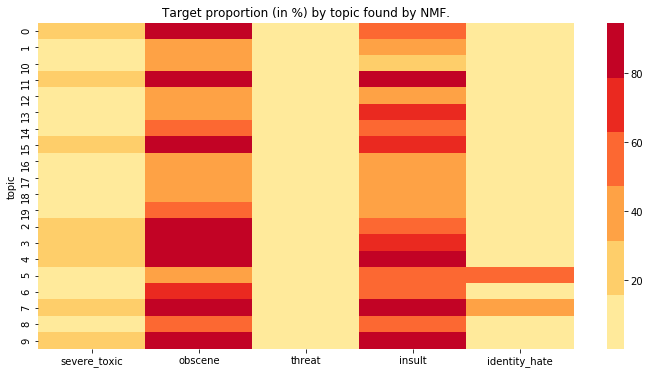

In [16]:
# we remove toxic label because it is the more represented (almost all toxic comment are labelled with "toxic")
plt.subplots(figsize=(12,6))
sns.heatmap(df_topic_targets_proportion.drop("toxic",axis=1), cmap = sns.color_palette("YlOrRd"))
plt.title("Target proportion (in %) by topic found by NMF.")
plt.show()

#### TSNE on NMF matrix

TSNE allow us to represent multi-dimensional data into 2D.

In [17]:
path_tsne_nmf = "../data/work/tsne_nmf.p"
if os.path.isfile(path_tsne_nmf):
    tsne_nmf = pickle.load(open(path_tsne_nmf, "rb"))
else:
    tsne_nmf = TSNE().fit_transform(weights)
    tsne_nmf = pd.DataFrame(tsne_nmf, index=weights.index, columns=['x', 'y'])
    tsne_nmf = pd.merge(
        tsne_nmf,
        weights.idxmax(axis=1).rename("topic").reset_index(),
        on="id")
    pickle.dump(tsne_nmf, open(path_tsne_nmf, "wb"))

/Users/Thomas/anaconda3/envs/kaggle_text_classification/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


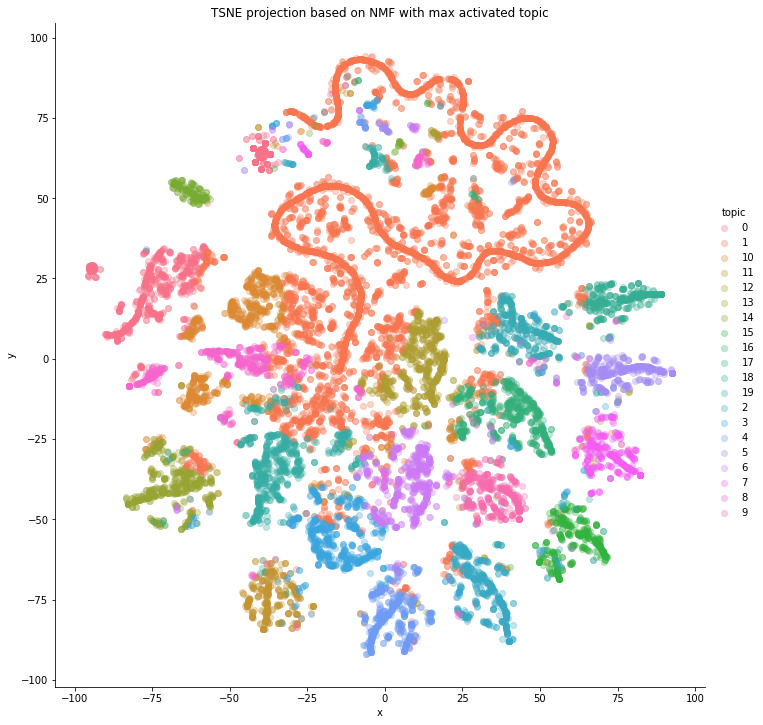

In [18]:
sns.lmplot(
    x="x",
    y="y",
    hue="topic",
    data=tsne_nmf,
    size=10,
    fit_reg=False,
    scatter_kws={
        'alpha': 0.3
    })
plt.title("TSNE projection based on NMF with max activated topic")
plt.show()